# CS 171 Final Project — Data Preparation Progress Update
### Waste Sorting with Classical ML + CNNs
**Authors:** Soham Bhowmick & Lwin Moe  
**Update Date:** Nov 23, 2025

This notebook shows the beginning of our data preparation process, focusing on the TACO dataset (waste images "in the wild"). The goal is to create a clean classification subset mapped to the TrashNet classes (cardboard, glass, metal, paper, plastic, trash).


## Project Goal (Short Summary)
Our project explores how well supervised learning models can classify common waste types.  
We compare:

- Classical ML (KNN, Logistic Regression, Decision Trees)
- Convolutional Neural Networks (CNNs)
- Ensemble majority voting

In this update, we show the beginning of our **data preparation work**, focusing on:
- loading TACO annotations  
- identifying relevant categories  
- inspecting images  
- preparing for 200×200 preprocessing and stratified splits  


## 1. Project Setup
- Create folders for TrashNet and TACO datasets
- Confirm dataset structure
- Load image paths
- Preview dataset statistics

In [25]:
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Path where you downloaded TACO
TACO_ROOT = "./data/TACO/data"   # <-- change if needed
ANNOTATION_FILE = os.path.join(TACO_ROOT, "annotations.json")

## Load TACO annotation json

In [14]:
with open(ANNOTATION_FILE, 'r') as f:
    data = json.load(f)

categories = data["categories"]
annotations = data["annotations"]
images = data["images"]

print("Total Images:", len(images))
print("Total Annotations:", len(annotations))
print("Total Categories:", len(categories))


Total Images: 1500
Total Annotations: 4784
Total Categories: 60


In [15]:
for c in categories:
    print(c["id"], c["name"])


0 Aluminium foil
1 Battery
2 Aluminium blister pack
3 Carded blister pack
4 Other plastic bottle
5 Clear plastic bottle
6 Glass bottle
7 Plastic bottle cap
8 Metal bottle cap
9 Broken glass
10 Food Can
11 Aerosol
12 Drink can
13 Toilet tube
14 Other carton
15 Egg carton
16 Drink carton
17 Corrugated carton
18 Meal carton
19 Pizza box
20 Paper cup
21 Disposable plastic cup
22 Foam cup
23 Glass cup
24 Other plastic cup
25 Food waste
26 Glass jar
27 Plastic lid
28 Metal lid
29 Other plastic
30 Magazine paper
31 Tissues
32 Wrapping paper
33 Normal paper
34 Paper bag
35 Plastified paper bag
36 Plastic film
37 Six pack rings
38 Garbage bag
39 Other plastic wrapper
40 Single-use carrier bag
41 Polypropylene bag
42 Crisp packet
43 Spread tub
44 Tupperware
45 Disposable food container
46 Foam food container
47 Other plastic container
48 Plastic glooves
49 Plastic utensils
50 Pop tab
51 Rope & strings
52 Scrap metal
53 Shoe
54 Squeezable tube
55 Plastic straw
56 Paper straw
57 Styrofoam piece
58

In [16]:
cat_id_to_name = {c['id']: c['name'] for c in categories}

## Extracting all images from selected categories

In [17]:
from collections import defaultdict

image_to_categories = defaultdict(list)

for ann in annotations:
    image_to_categories[ann['image_id']].append(cat_id_to_name[ann['category_id']])

## Previewing a few samples

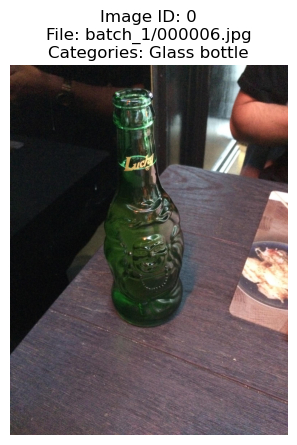

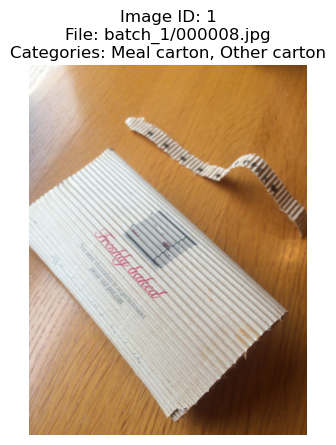

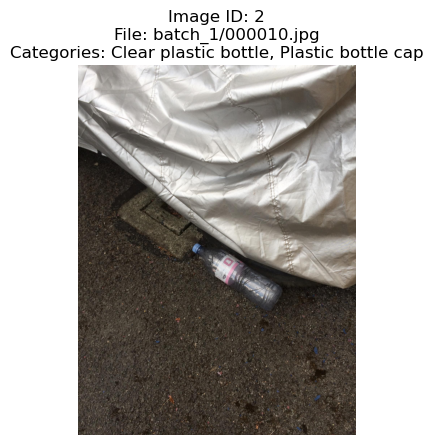

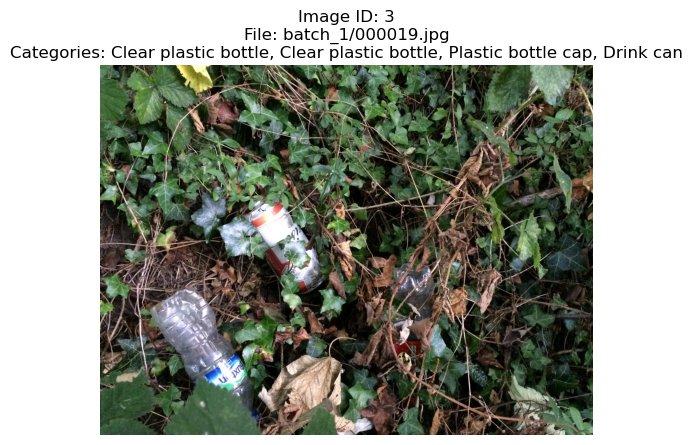

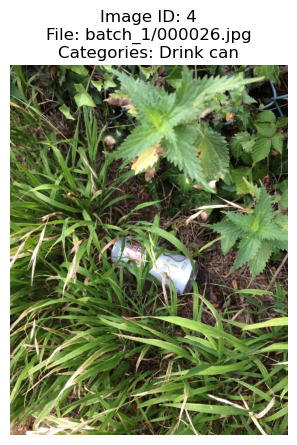

In [18]:
sample_ids = list(image_to_categories.keys())[:5]

for img_id in sample_ids:
    # Get image info
    img_info = next(i for i in images if i["id"] == img_id)
    img_path = os.path.join(TACO_ROOT, img_info["file_name"])

    # Make sure file exists
    if not os.path.exists(img_path):
        print(f"File not found: {img_path}")
        continue

    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Image ID: {img_id}\n"
              f"File: {img_info['file_name']}\n"
              f"Categories: {', '.join(image_to_categories[img_id])}")
    plt.show()


This looks good. Lets create some folder structure.

## 1. Creating folders

Goal: Organize the classification dataset into categories
This allows PyTorch’s ImageFolder and all our models to load images easily.

In [20]:
BASE_DIR = "TACO_clean"
CLASSES = [c["name"] for c in categories]

for c in CLASSES:
    path = os.path.join(BASE_DIR, c)
    os.makedirs(path, exist_ok=True)

print("Folder structure created!")


Folder structure created!


## 2. Copy & Resize Images (200×200)

- Take raw TACO images

- Map them to our classes

- Resize all images to 200×200

- Save images into the proper class folders

This ensures all images have the same size before training CNNs.

In [23]:
BASE_DIR = "TACO_clean"
SOURCE_DIR = TACO_ROOT

image_to_categories = defaultdict(list)
for ann in annotations:
    cat_id = ann["category_id"]
    cat_name = next(c["name"] for c in categories if c["id"] == cat_id)
    image_to_categories[ann["image_id"]].append(cat_name)

def process_and_copy(img_path, dest_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((200, 200))  # resize to 200x200
    img.save(dest_path)

for img_info in images:
    img_id = img_info["id"]
    img_file = img_info["file_name"]
    full_path = os.path.join(SOURCE_DIR, img_file)
    
    # Skip missing files
    if not os.path.exists(full_path):
        print(f"File not found: {full_path}")
        continue
    
    # Some images have multiple categories; copy into each category folder
    categories_for_img = image_to_categories[img_id]
    for cat_name in categories_for_img:
        dest_path = os.path.join(BASE_DIR, cat_name, os.path.basename(img_file))
        process_and_copy(full_path, dest_path)

print("All images copied and resized!")

All images copied and resized!


## 3. Compute Dataset Statistics (Mean & Std)

- Compute the mean and standard deviation of all images in the new dataset.

These values are required for:

- Normalizing images before training a CNN

- Matching common vision ML pipelines

- Ensuring stable model convergence

In [27]:
means = []
stds = []

for cat_name in CLASSES:
    folder = os.path.join(BASE_DIR, cat_name)
    for img_name in os.listdir(folder):
        img = np.array(Image.open(os.path.join(folder, img_name))) / 255.0
        means.append(img.mean(axis=(0,1)))
        stds.append(img.std(axis=(0,1)))

dataset_mean = np.mean(means, axis=0)
dataset_std  = np.mean(stds, axis=0)

print("Dataset mean:", dataset_mean)
print("Dataset std:", dataset_std)


Dataset mean: [0.49346783 0.46488915 0.41210594]
Dataset std: [0.18972134 0.18034764 0.17640931]


## 4. Creating train/val/test splits

In [32]:

# Creating train/val/test splits
# 70% train, 15% val, 15% test


data = []

for cat_name in CLASSES:
    folder = os.path.join(BASE_DIR, cat_name)
    if not os.path.exists(folder) or len(os.listdir(folder)) == 0:
        print(f"Skipping empty folder: {folder}")
        continue
    for img_name in os.listdir(folder):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            data.append([os.path.join(folder, img_name), cat_name])

df = pd.DataFrame(data, columns=["filepath", "label"])
print("Images per class before filtering:\n", df['label'].value_counts())


# Identify singleton classes (1 image) and put in train
counts = df['label'].value_counts()
singleton_classes = counts[counts == 1].index.tolist()
singleton_df = df[df['label'].isin(singleton_classes)]
df_rest = df[~df['label'].isin(singleton_classes)]
print("Singleton classes:", singleton_classes)


# Stratified split on df_rest (only classes with >=2 images)
train_df, temp_df = train_test_split(
    df_rest, test_size=0.3, stratify=df_rest['label'], random_state=42
)


# Handle tiny classes in temp_df (classes with <2 images)
counts_temp = temp_df['label'].value_counts()
tiny_classes = counts_temp[counts_temp < 2].index.tolist()
if tiny_classes:
    print("Tiny classes in temp_df:", tiny_classes)
    tiny_df = temp_df[temp_df['label'].isin(tiny_classes)]
    temp_df = temp_df[~temp_df['label'].isin(tiny_classes)]
else:
    tiny_df = pd.DataFrame(columns=temp_df.columns)

# Stratified split for remaining temp_df
if len(temp_df) > 0:
    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42
    )
else:
    val_df, test_df = pd.DataFrame(columns=df.columns), pd.DataFrame(columns=df.columns)

# Put singleton and tiny classes into train
train_df = pd.concat([train_df, singleton_df, tiny_df], ignore_index=True)

print("Train/Val/Test sizes:", train_df.shape, val_df.shape, test_df.shape)


os.makedirs("splits", exist_ok=True)
train_df.to_csv("splits/train.csv", index=False)
val_df.to_csv("splits/val.csv", index=False)
test_df.to_csv("splits/test.csv", index=False)
print("CSV files saved!")


Skipping empty folder: TACO_clean/Plastified paper bag
Images per class before filtering:
 label
Plastic film                 137
Unlabeled litter             123
Clear plastic bottle         114
Cigarette                    106
Plastic bottle cap           105
Drink can                    104
Other plastic                104
Other plastic wrapper         94
Plastic straw                 76
Styrofoam piece               68
Disposable plastic cup        64
Pop tab                       63
Glass bottle                  62
Other carton                  62
Normal paper                  60
Paper cup                     54
Plastic lid                   51
Metal bottle cap              49
Other plastic bottle          41
Aluminium foil                40
Single-use carrier bag        38
Corrugated carton             37
Drink carton                  37
Crisp packet                  34
Disposable food container     32
Tissues                       31
Meal carton                   27
Rope & strin